In [1]:
import numpy as np 
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
import random
import argparse
import networkx as nx
import os
from itertools import combinations
import time

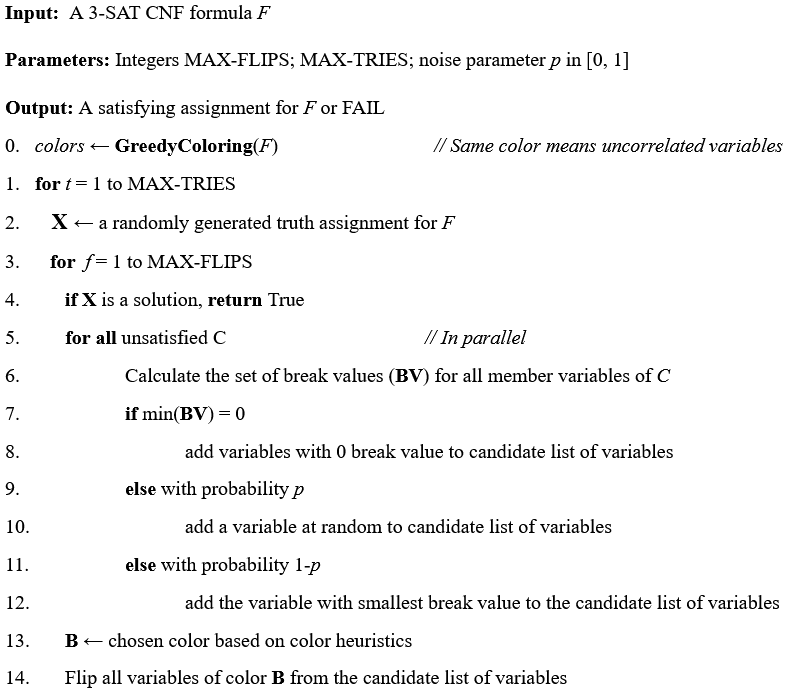

In [2]:
def read_dimacs(filename): # int num_vars, array clauses
    clauses = []
    with open(filename, 'r') as file:
        for line in file:
            if line.startswith('p'):
                parts = line.strip().split()
                if len(parts) >= 4:
                    _, _, variables, _ = parts[:4]
                    num_vars = int(variables)
                else:
                    raise ValueError("Invalid CNF file format in 'p' line.")
            elif line.startswith('c') or line.startswith('%') or line.startswith('0'):
                continue
            else:
                clause = list(map(int, line.strip().split()))
                # Remove the trailing 0 if present
                if clause and clause[-1] == 0:
                    clause = clause[:-1]
                if clause:
                    clauses.append(clause)
    return num_vars, clauses

def extract_problem_number(filename) -> int:
    """Extract numerical problem number from filename."""
    basename = os.path.basename(filename)
    num_str = ''.join(filter(str.isdigit, basename)) # jank the digits
    return int(num_str)


In [3]:
def walkSAT(clauses, max_tries, max_flips, p): # assignment, _Tries, _Flips, flips
    flips = 0
    def evaluate_clause(clause, assignment):
        return any((var > 0 and assignment.get(abs(var), False)) or 
                   (var < 0 and not assignment.get(abs(var), False)) for var in clause)

    def get_unsatisfied_clauses(clauses, assignment):
        return [clause for clause in clauses if not evaluate_clause(clause, assignment)]

    def get_variables(clauses):
        return set(abs(var) for clause in clauses for var in clause)

    def flip_variable(assignment, var):
        assignment[var] = not assignment[var]

    for _Tries in range(max_tries):
        variables = list(get_variables(clauses))
        assignment = {var: random.choice([True, False]) for var in variables}
        
        for _Flips in range(max_flips):

            unsatisfied = get_unsatisfied_clauses(clauses, assignment)
            if not unsatisfied:
                return assignment, _Tries, _Flips, flips  # Found a satisfying assignment
            
            clause = random.choice(unsatisfied)
            if random.random() < p:
                # Flip a random variable from the clause
                var_to_flip = abs(random.choice(clause))
            else:
                # Flip a variable that minimizes the number of unsatisfied clauses if flipped
                break_counts = []
                for var in clause:
                    assignment[abs(var)] = not assignment[abs(var)]
                    break_counts.append((len(get_unsatisfied_clauses(clauses, assignment)), abs(var)))
                    assignment[abs(var)] = not assignment[abs(var)]  # Undo the flip
                
                min_break = min(break_counts, key=lambda x: x[0])
                vars_with_min_break = [var for break_count, var in break_counts if break_count == min_break[0]]
                var_to_flip = random.choice(vars_with_min_break)
            
            flip_variable(assignment, var_to_flip)
            flips += 1

    return "FAIL"

In [4]:
from itertools import combinations

def evaluate_clause(clause, assignment):
    return any(
        (var > 0 and assignment.get(abs(var), False)) or
        (var < 0 and not assignment.get(abs(var), False))
        for var in clause
    )

def get_unsatisfied_clauses(clauses, assignment):
    return [clause for clause in clauses if not evaluate_clause(clause, assignment)]

def get_variables(clauses):
    return set(abs(var) for clause in clauses for var in clause)

def flip_variable(assignment, var):
    assignment[var] = not assignment[var]

def GenerateColors(clauses):
    variables = set(abs(literal) for clause in clauses for literal in clause)
    G = nx.Graph()
    G.add_nodes_from(variables)  # Variable adjacency graph

    # If variables appear in the same clause, make an edge
    for clause in clauses:
        vars_in_clause = set(abs(literal) for literal in clause)
        for var1, var2 in combinations(vars_in_clause, 2):
            G.add_edge(var1, var2)

    # Greedy coloring , return dictionary of unique colors (0 to n) for each node
    colors = nx.coloring.greedy_color(G, strategy='largest_first')
    return colors

In [5]:
def process_clause(clause, assignment, clauses, p, color_array):
    variables_in_clause = np.abs(np.array(clause, dtype=int))
    break_counts = []

    # Line 6) Calculate set of break values for all unsat C
    for x in variables_in_clause:
        assignment[x] = ~assignment[x]
        num_new_unsat = 0
        for clause_check in clauses:
            literals_check = np.array(clause_check, dtype=int)
            vars_in_clause_check = np.abs(literals_check).astype(int)
            signs_check = literals_check > 0
            clause_values_check = assignment[vars_in_clause_check]
            clause_evaluation_check = np.where(signs_check, clause_values_check, ~clause_values_check)
            if not np.any(clause_evaluation_check):
                num_new_unsat += 1
        break_counts.append(num_new_unsat)
        assignment[x] = ~assignment[x]

    candidate_list_of_variables = set() # avoid repeats
    if 0 in break_counts:
        freebie = variables_in_clause[break_counts.index(0)]
        candidate_list_of_variables.add((freebie, color_array[freebie]))

    # Pick a random variable or the min-break variable based on p
    if random.random() < p:
        x = np.random.choice(variables_in_clause)
    else:
        min_break = np.min(break_counts)
        min_indices = np.where(break_counts == min_break)[0]
        idx_min = np.random.choice(min_indices)
        x = variables_in_clause[idx_min]
    candidate_list_of_variables.add((x, color_array[x]))
    candidate_list_of_variables = list(candidate_list_of_variables)
    return candidate_list_of_variables

In [6]:
# Algorithm A1 Steps (v2):
import concurrent.futures
def AlgorithmA1(clauses, colors, max_tries, max_flips, p, heuristic_mode=0):
    """    
    clauses: array of clauses from read_cnf() 
    colors: dictionary of color memberships from GenerateColors()
    max_tries: integer of max restarts for algorithm
    max_flips: integer of iterations of algorithm for a given try
    p: probability of greedy vs random selection
    heuristic_mode: 
        0 = greedy in colors from candidate variables to flip
        1 = random from candidate variables to flip
        2 = pick a random color from candidate variables to flip
        3 = always pick first candidate variable in the candidate variables to flip
    """
    color_choice_history = [] # needed this to track how heuristic choices impact the convergence
    flips = 0
    variables = np.array(sorted(get_variables(clauses))) # Sorted list of variables
    # 1-based indexing, because 0 in cnf files is used for line breaks
    num_vars = variables[-1]
    color_array = np.zeros(num_vars + 1, dtype=int)
    for var, color in colors.items():
        color_array[var] = color
    unique_colors = np.unique(color_array[color_array > 0]) # number of unique colors
    
    for _try in range(max_tries):
        # Line 2) Random assignment
        assignment = np.random.choice([True, False], size=num_vars + 1)  # 1 based indexing

        for _flip in range(max_flips):
            # Line 5.a) Gather indeces of UNSAT clauses
            unsat_indices = []
            for idx, clause in enumerate(clauses):
                literals = np.array(clause, dtype=int)
                vars_in_clause = np.abs(literals).astype(int)
                signs = literals > 0
                clause_values = assignment[vars_in_clause]  # Get assignment values
                clause_evaluation = np.where(signs, clause_values, ~clause_values)
                # If none evaluate to 1, add to unsat index
                if not np.any(clause_evaluation):
                    unsat_indices.append(idx)

            if not unsat_indices: # Line 4) If assignment is a solution, return True
                return assignment[1:], _try, _flip, flips, color_choice_history #_flip is iteration count, flips is actual flips

            # Line 5.b) Gather UNSAT clauses
            selected_clauses = [clauses[i] for i in unsat_indices]
            candidate_list_of_variables = []

            with concurrent.futures.ThreadPoolExecutor() as executor: # Line 5) Should be in parallel.
                futures = []
                for clause in selected_clauses:
                    # Use assignment.copy() if you need to avoid concurrent mutation
                    futures.append(
                        executor.submit(process_clause, clause, assignment.copy(),
                                        clauses, p, color_array)
                    )

                for future in concurrent.futures.as_completed(futures):
                    candidate_list_of_variables.extend(future.result())

            # Line 13) Prepare the candidate list of variables for heuristics
            color_to_candidates = {}
            for x, color in candidate_list_of_variables:
                color_to_candidates.setdefault(color, []).append(x)

            # Line 14) Flip all variables of color B based on heuristics:
            # 1/4/25 added color tracking 
            if heuristic_mode == 0:
                # 5a) Flip variables of the color with the largest number of variables
                selected_color = max(color_to_candidates.keys(), key=lambda c: len(color_to_candidates[c]))
                candidates_in_color = color_to_candidates[selected_color]
                assignment[candidates_in_color] = ~assignment[candidates_in_color]
                flips += len(candidates_in_color)
                color_choice_history.append({"color": selected_color, "flips": len(candidates_in_color)})
            elif heuristic_mode == 1:
                # 5b) Randomly pick a variable from candidate variables to flip
                var_to_flip = np.random.choice([x for x, _ in candidate_list_of_variables])
                assignment[var_to_flip] = ~assignment[var_to_flip]
                flips += 1
                color_choice_history.append({"color": color_array[var_to_flip], "flips": 1})
            elif heuristic_mode == 2:
                # 5c) Randomly pick a color, flip all variables of that color
                selected_color = np.random.choice(list(color_to_candidates.keys()))
                candidates_in_color = color_to_candidates[selected_color]
                assignment[candidates_in_color] = ~assignment[candidates_in_color]
                flips += len(candidates_in_color)
                color_choice_history.append({"color": selected_color, "flips": len(candidates_in_color)})
            elif heuristic_mode == 3:
                # 5d) Always pick the first candidate variable to flip
                var_to_flip = candidate_list_of_variables[0][0]
                assignment[var_to_flip] = ~assignment[var_to_flip]
                flips += 1
                color_choice_history.append({"color": color_array[var_to_flip], "flips": 1})
    return "FAIL"

In [7]:
max_flips_var = 10000
noise_value = 0.5
chosen_heuristic = 0 
chosen_max_tries = 10
cnf_file = "/home/dae/SatExperiments/ColoringWalksatExperiments/TestFolderCNF/uf5004.cnf"
problem_name = os.path.basename(cnf_file)
num_vars, clauses = read_dimacs(cnf_file)
start = time.perf_counter()
colors = GenerateColors(clauses)
solution_object = AlgorithmA1(clauses, colors, max_tries=chosen_max_tries, max_flips=max_flips_var, p=noise_value, heuristic_mode=chosen_heuristic)
end = time.perf_counter()

In [8]:
solution_object

(array([ True,  True, False,  True,  True, False, False,  True,  True,
         True, False,  True,  True, False, False, False,  True, False,
        False, False,  True, False,  True,  True,  True, False,  True,
        False, False, False,  True, False, False, False,  True, False,
        False,  True, False, False,  True, False, False,  True, False,
         True, False,  True,  True, False]),
 0,
 382,
 550,
 [{'color': 4, 'flips': 7},
  {'color': 0, 'flips': 5},
  {'color': 5, 'flips': 5},
  {'color': 1, 'flips': 2},
  {'color': 1, 'flips': 3},
  {'color': 3, 'flips': 2},
  {'color': 3, 'flips': 2},
  {'color': 6, 'flips': 2},
  {'color': 2, 'flips': 4},
  {'color': 2, 'flips': 4},
  {'color': 0, 'flips': 2},
  {'color': 2, 'flips': 2},
  {'color': 6, 'flips': 3},
  {'color': 8, 'flips': 3},
  {'color': 2, 'flips': 2},
  {'color': 8, 'flips': 3},
  {'color': 1, 'flips': 2},
  {'color': 2, 'flips': 2},
  {'color': 2, 'flips': 5},
  {'color': 2, 'flips': 2},
  {'color': 2, 'flips': 

In [9]:
# import os
# import glob
# import json
# import time
# import matplotlib.pyplot as plt
# import multiprocessing
# import numpy as np

# cnf_file = "/home/dae/SatExperiments/ColoringWalksatExperiments/uf50suiteSATLIB/uf5002.cnf"
# problem_name = os.path.basename(cnf_file)
# num_vars, clauses = read_dimacs(cnf_file)
# start = time.perf_counter()
# colors = GenerateColors(clauses)
# max_flips_var = 10000 # same as tinish paper

# # 1 29s
# # 0 is taking 57
# # 2  151
# # 3 22s
# solution_object = AlgorithmA1(clauses, colors, max_tries=1, max_flips=max_flips_var, p=0.5, heuristic_mode=0)
# end = time.perf_counter()
# print(str((end-start)))

In [10]:
# import matplotlib.pyplot as plt
# from collections import Counter

# if solution_object != "FAIL":
#     assignment, tries, iterations, flips, color_order =  solution_object
    
#     # assignment = true false true comma separated
#     # tries (int)
#     # iterations (int)
#     # flips (int)
#     # color_order of the form: 
#     # [{'color': 7, 'flips': 5},
#     # {'color': 0, 'flips': 5},
#     # {'color': 4, 'flips': 6},
#     colors = [entry["color"] for entry in color_order]
#     counts = Counter(colors)
#     # Assign a unique color to each bar
#     unique_colors = list(counts.keys())
#     bar_colors = plt.cm.tab20(np.linspace(0, 1, len(unique_colors)))  # Use a colormap for distinct colors

#     plt.figure(figsize=(8, 5))
#     plt.bar(counts.keys(), counts.values(), color=bar_colors, edgecolor="black")
#     plt.xlabel("Color")
#     plt.ylabel("Frequency")
#     plt.title("Frequency of Color Choices")
#     plt.grid(axis="y", linestyle="--", alpha=0.7)
#     plt.show()

    
#     flips = [entry["flips"] for entry in color_order]
#     plt.stem(range(iterations), flips)
#     plt.xlabel("Iteration")
#     plt.ylabel("Flips")
#     plt.title("Flips per Iteration")
#     plt.grid(axis="y", linestyle="--", alpha=0.7)
#     max_flips = max(flips)
#     plt.yticks(np.arange(0, max_flips + 1, 1))
#     plt.show()


In [11]:
# import matplotlib.pyplot as plt
# import matplotlib.colors as mcolors
# import numpy as np

# # Example data
# colors = [entry["color"] for entry in color_order]

# # Generate unique colors for each y-axis value
# unique_colors = sorted(set(colors))
# color_map = plt.cm.tab20(np.linspace(0, 1, len(unique_colors)))  # Colormap for distinct colors
# color_dict = {color: color_map[i] for i, color in enumerate(unique_colors)}

# # Plot the scatter plot with unique colors
# plt.figure(figsize=(10, 6))
# for i, color in enumerate(colors):
#     plt.scatter(i, color, color=color_dict[color], label=f"Color {color}" if i == 0 else "", s=50)

# # Add horizontal gridlines corresponding to unique colors
# for y_value in unique_colors:
#     plt.axhline(y=y_value, color=color_dict[y_value], linestyle="--", alpha=0.5)

# # Labels and titles
# plt.xlabel("Iteration Number")
# plt.ylabel("Chosen Color")
# plt.title("Color Choices Over Iterations")
# plt.grid(axis="x", linestyle="--", alpha=0.5)  # Add light gridlines for x-axis

# # Add a legend to distinguish y-axis colors
# handles = [plt.Line2D([0], [0], marker='o', color=color_dict[color], linestyle='', markersize=8) 
#            for color in unique_colors]
# labels = [f"Color {color}" for color in unique_colors]
# plt.legend(handles, labels, title="Y-axis Colors", bbox_to_anchor=(1.05, 1), loc='upper left')

# # Show the plot
# plt.tight_layout()
# plt.show()


In [12]:
# Now what to plot:

# a Run length distribution
# b Success rate - modify below code with tinish def
# c Instance-wise flips to solution (done; just a number)
# d Batch wise flips to solution (done) - modify below code

# e Color choice distribution for the batch - take the per-instance and do for batch (most common)
# f Color choice during solving per instance (done above)
# g Color choice domain plots with instance-wise flips to solution range (combine e and c)
# h Parallelism % domain heuristic plots with instance-wise flips to solution range (needs new)

In [ ]:
# Modified just to run everything no plots
# then dumps to a sql
# also the metricsare in myWalksat.py
# 01/13/2025: modified so I can append 100 times instead of setting max_tries == 100...
# because otherwise, huzzah I cannot find the TTS99 idea properly

import sqlite3
import os
import glob
import json
import time
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
from collections import Counter
import pandas as pd

def process_file(cnf_file):
    import time
    max_flips_var = 10000
    noise_value = 0.5
    chosen_heuristic = 0 
    chosen_max_tries = 1

    problem_name = os.path.basename(cnf_file)
    num_vars, clauses = read_dimacs(cnf_file)
    start = time.perf_counter()
    colors = GenerateColors(clauses)
    solution_object = AlgorithmA1(clauses, colors, max_tries=chosen_max_tries, max_flips=max_flips_var, p=noise_value, heuristic_mode=chosen_heuristic)
    end = time.perf_counter()

    # flips is taken flips, iterations is what flips stands for in regular wsat
    # this is confusing - change structure

    if solution_object != "FAIL":  # we found a satisfying model
        time_to_solution = end - start  # seconds
        assignment, tries, iterations, flips, color_order =  solution_object
        print(f"{problem_name}: Time = {time_to_solution:.4f}s, Flips = {flips}")
        colors_order_iter = [entry["color"] for entry in color_order]
        flips_iter = [entry["flips"] for entry in color_order]
        counts = Counter(colors)
        return (problem_name, time_to_solution, noise_value, tries, iterations, flips, colors_order_iter, flips_iter) # tuple of problem name, TTS, flips
    else:
        print(f"{problem_name}: Failed to find a solution")
        # Return None for time and flips (thanks George for suggestion)
        return (problem_name, None, None, None, None, None, None, None)


# changed this to append to the save csv over and over again up to the 100 tries we needed.
# so now 100 tries of 1 maxtries each
def main():
    # CSV file path
    csv_file = 'Coloring_H0_Uf50_P05_Tries100_Flips10000.csv'
    
    # Remove existing CSV to start fresh
    if os.path.exists(csv_file):
        os.remove(csv_file)
        print(f"Existing CSV '{csv_file}' removed. Starting fresh.")

    cnf_directory = "/home/dae/SatExperiments/ColoringWalksatExperiments/uf50suiteSATLIB/"
    cnf_files = glob.glob(os.path.join(cnf_directory, "uf50*.cnf")) # get all uf50* files
    cnf_files.sort(key=extract_problem_number) # sort files based on numerical part filename

    total_cpus = multiprocessing.cpu_count()
    num_workers = max(1, int(total_cpus * 0.9)) # using 60% of cores
    print(f"Total CPU cores: {total_cpus}, Using {num_workers} worker processes.")

    # Open the CSV file in append mode
    for run_id in range(1, 101):  # Runs 1 to 100
        print(f"Starting run {run_id}/100")
        with multiprocessing.Pool(processes=num_workers) as pool: # do the benchmarking in parallel
            results = pool.map(process_file, cnf_files)

        if results: # problem_names, times_to_solution, p, tries_to_solution, iterations_to_solution, flips_to_solution, colors_order_iter_list, flips_iter_list
            problem_names, times_to_solution, p, tries_to_solution, iterations_to_solution, flips_to_solution, colors_order_iter_list, flips_iter_list = zip(*results)
            
            dict_results = {
                'run_id': [run_id]*len(problem_names),
                'problem_name': problem_names, 
                'time_to_solution': times_to_solution, 
                'noise_param': p, 
                'tries': tries_to_solution, 
                'iterations': iterations_to_solution, 
                'flips': flips_to_solution,
                'order_of_colors': colors_order_iter_list, 
                'order_of_parallel_flips': flips_iter_list
            }    
            df = pd.DataFrame(dict_results)
            
            # Append to CSV
            if run_id == 1:
                df.to_csv(csv_file, mode='w', index=False)
                print(f"Run {run_id}: Data written to '{csv_file}' with headers.")
            else:
                df.to_csv(csv_file, mode='a', header=False, index=False)
                print(f"Run {run_id}: Data appended to '{csv_file}'.")
        else:
            print("No results error in run {run_id}.")
            continue  # Proceed to the next run

    print("All runs completed.")

if __name__ == "__main__":
    main()


Total CPU cores: 64, Using 57 worker processes.
Starting run 1/100
uf5004.cnf: Time = 9.0294s, Flips = 644


KeyboardInterrupt: 

In [15]:
# Modified just to run everything no plots
# then dumps to a sql
# also the metricsare in myWalksat.py

# next time let's do sqlite database again
import sqlite3
import os
import glob
import json
import time
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
from collections import Counter
import pandas as pd

# Note: change prints to logs

# ML-style checkpoints, in case this crashes. Json.
# wip haven't implemented
# h = heuristic
# uf50 = dataset
# tries = n of maxtries
# flips = n of maxflips
# p = noise value 00 out of 10 i.e. 0.0 out of 1.0

def process_file(cnf_file):
    import time
    max_flips_var = 10000
    noise_value = 0.5
    chosen_heuristic = 2 
    chosen_max_tries = 1

    problem_name = os.path.basename(cnf_file)
    num_vars, clauses = read_dimacs(cnf_file)
    start = time.perf_counter()
    colors = GenerateColors(clauses)
    solution_object = AlgorithmA1(clauses, colors, max_tries=chosen_max_tries, max_flips=max_flips_var, p=noise_value, heuristic_mode=chosen_heuristic)
    end = time.perf_counter()

    # flips is taken flips, iterations is what flips stands for in regular wsat
    # this is confusing - change structure

    if solution_object != "FAIL":  # we found a satisfying model
        time_to_solution = end - start  # seconds
        assignment, tries, iterations, flips, color_order =  solution_object
        print(f"{problem_name}: Time = {time_to_solution:.4f}s, Flips = {flips}")
        colors_order_iter = [entry["color"] for entry in color_order]
        flips_iter = [entry["flips"] for entry in color_order]
        counts = Counter(colors)
        return (problem_name, time_to_solution, noise_value, tries, iterations, flips, colors_order_iter, flips_iter) # tuple of problem name, TTS, flips
    else:
        print(f"{problem_name}: Failed to find a solution")
        # Return None for time and flips (thanks George for suggestion)
        return (problem_name, None, None, None, None, None, None, None, None)

def main():
    problem_names = []
    times_to_solution = []
    flips_to_solution = []
    # for debugging /home/dae/SatExperiments/ColoringWalksatExperiments/TestFolderCNF "/home/dae/SatExperiments/ColoringWalksatExperiments/uf50suiteSATLIB/"
    cnf_directory = "/home/dae/SatExperiments/ColoringWalksatExperiments/uf50suiteSATLIB/"
    cnf_files = glob.glob(os.path.join(cnf_directory, "uf50*.cnf")) # get all uf50* files
    cnf_files.sort(key=extract_problem_number) # sort files based on  numerical part of the filename

    total_cpus = multiprocessing.cpu_count()
    num_workers = max(1, int(total_cpus * 0.3)) # use 20% of cores
    print(f"Total CPU cores: {total_cpus}, Using {num_workers} worker processes.")

    with multiprocessing.Pool(processes=num_workers) as pool: # do the benchmarking in parallel
        results = pool.map(process_file, cnf_files)

    if results: # problem_names, times_to_solution, p, tries_to_solution, iterations_to_solution, flips_to_solution, colors_order_iter_list, flips_iter_list
        problem_names, times_to_solution, p, tries_to_solution, iterations_to_solution, flips_to_solution, colors_order_iter_list, flips_iter_list = zip(*results)
        
        dict_results = {'problem_name': problem_names, 'time_to_solution': times_to_solution, 'noise_param': p, 
                        'tries': tries_to_solution, 'iterations': iterations_to_solution, 'flips': flips_to_solution,
                        'order_of_colors': colors_order_iter_list, 'order_of_parallel_flips': flips_iter_list
                        }    
        df = pd.DataFrame(dict_results)
        df.to_csv('Coloring_H2_Uf50_P05_Tries1_Flips10000.csv')
    else:
        print("No results error.")
        return
    
if __name__ == "__main__":
    main()


Total CPU cores: 64, Using 19 worker processes.
uf500253.cnf: Time = 1.2968s, Flips = 31
uf50029.cnf: Time = 3.0238s, Flips = 81
uf500183.cnf: Time = 3.9000s, Flips = 162
uf500141.cnf: Time = 4.2380s, Flips = 73
uf50015.cnf: Time = 4.3587s, Flips = 119
uf500169.cnf: Time = 4.4258s, Flips = 122
uf5001.cnf: Time = 5.3202s, Flips = 107
uf500239.cnf: Time = 6.8313s, Flips = 307
uf50085.cnf: Time = 7.9982s, Flips = 456
uf500184.cnf: Time = 4.2149s, Flips = 122
uf500254.cnf: Time = 6.8421s, Flips = 216
uf50099.cnf: Time = 9.2912s, Flips = 346
uf500185.cnf: Time = 2.6082s, Flips = 108
uf500211.cnf: Time = 13.8341s, Flips = 591
uf50043.cnf: Time = 13.9829s, Flips = 464
uf500225.cnf: Time = 14.5887s, Flips = 420
uf50071.cnf: Time = 15.4072s, Flips = 464
uf500113.cnf: Time = 15.8924s, Flips = 580
uf500212.cnf: Time = 4.2428s, Flips = 159
uf500114.cnf: Time = 2.5420s, Flips = 67
uf50044.cnf: Time = 5.5737s, Flips = 190
uf500115.cnf: Time = 4.0946s, Flips = 138
uf500155.cnf: Time = 23.7676s, Flips

In [16]:
# Modified just to run everything no plots
# then dumps to a sql
# also the metricsare in myWalksat.py

# next time let's do sqlite database again
import sqlite3
import os
import glob
import json
import time
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
from collections import Counter
import pandas as pd

# Note: change prints to logs

# ML-style checkpoints, in case this crashes. Json.
# wip haven't implemented
# h = heuristic
# uf50 = dataset
# tries = n of maxtries
# flips = n of maxflips
# p = noise value 00 out of 10 i.e. 0.0 out of 1.0

def process_file(cnf_file):
    import time
    max_flips_var = 10000
    noise_value = 0.5
    chosen_heuristic = 0 
    chosen_max_tries = 100

    problem_name = os.path.basename(cnf_file)
    num_vars, clauses = read_dimacs(cnf_file)
    start = time.perf_counter()
    colors = GenerateColors(clauses)
    solution_object = AlgorithmA1(clauses, colors, max_tries=chosen_max_tries, max_flips=max_flips_var, p=noise_value, heuristic_mode=chosen_heuristic)
    end = time.perf_counter()

    # flips is taken flips, iterations is what flips stands for in regular wsat
    # this is confusing - change structure

    if solution_object != "FAIL":  # we found a satisfying model
        time_to_solution = end - start  # seconds
        assignment, tries, iterations, flips, color_order =  solution_object
        print(f"{problem_name}: Time = {time_to_solution:.4f}s, Flips = {flips}")
        colors_order_iter = [entry["color"] for entry in color_order]
        flips_iter = [entry["flips"] for entry in color_order]
        counts = Counter(colors)
        return (problem_name, time_to_solution, noise_value, tries, iterations, flips, colors_order_iter, flips_iter) # tuple of problem name, TTS, flips
    else:
        print(f"{problem_name}: Failed to find a solution")
        # Return None for time and flips (thanks George for suggestion)
        return (problem_name, None, None, None, None, None, None, None, None)

def main():
    problem_names = []
    times_to_solution = []
    flips_to_solution = []
    # for debugging /home/dae/SatExperiments/ColoringWalksatExperiments/TestFolderCNF "/home/dae/SatExperiments/ColoringWalksatExperiments/uf50suiteSATLIB/"
    cnf_directory = "/home/dae/SatExperiments/ColoringWalksatExperiments/uf50suiteSATLIB/"
    cnf_files = glob.glob(os.path.join(cnf_directory, "uf50*.cnf")) # get all uf50* files
    cnf_files.sort(key=extract_problem_number) # sort files based on  numerical part of the filename

    total_cpus = multiprocessing.cpu_count()
    num_workers = max(1, int(total_cpus * 0.3)) # use 20% of cores
    print(f"Total CPU cores: {total_cpus}, Using {num_workers} worker processes.")

    with multiprocessing.Pool(processes=num_workers) as pool: # do the benchmarking in parallel
        results = pool.map(process_file, cnf_files)

    if results: # problem_names, times_to_solution, p, tries_to_solution, iterations_to_solution, flips_to_solution, colors_order_iter_list, flips_iter_list
        problem_names, times_to_solution, p, tries_to_solution, iterations_to_solution, flips_to_solution, colors_order_iter_list, flips_iter_list = zip(*results)
        
        dict_results = {'problem_name': problem_names, 'time_to_solution': times_to_solution, 'noise_param': p, 
                        'tries': tries_to_solution, 'iterations': iterations_to_solution, 'flips': flips_to_solution,
                        'order_of_colors': colors_order_iter_list, 'order_of_parallel_flips': flips_iter_list
                        }    
        df = pd.DataFrame(dict_results)
        df.to_csv('Coloring_H0_Uf50_P05_Tries100_Flips10000.csv')
    else:
        print("No results error.")
        return
    
if __name__ == "__main__":
    main()


Total CPU cores: 64, Using 19 worker processes.
uf500169.cnf: Time = 1.2345s, Flips = 51
uf500239.cnf: Time = 2.4502s, Flips = 104
uf50015.cnf: Time = 3.9157s, Flips = 184
uf50043.cnf: Time = 4.3625s, Flips = 180
uf500127.cnf: Time = 5.1406s, Flips = 291
uf50085.cnf: Time = 5.7818s, Flips = 459
uf50044.cnf: Time = 2.4241s, Flips = 82
uf500113.cnf: Time = 8.1337s, Flips = 551
uf500225.cnf: Time = 9.7312s, Flips = 719
uf500226.cnf: Time = 1.0347s, Flips = 43
uf500141.cnf: Time = 12.0648s, Flips = 669
uf500114.cnf: Time = 4.3004s, Flips = 187
uf50099.cnf: Time = 12.8042s, Flips = 1007
uf500115.cnf: Time = 0.8141s, Flips = 38
uf5001.cnf: Time = 14.0237s, Flips = 824
uf500170.cnf: Time = 13.1130s, Flips = 790
uf500155.cnf: Time = 14.7679s, Flips = 1014
uf50045.cnf: Time = 8.1822s, Flips = 423
uf500128.cnf: Time = 12.2325s, Flips = 692
uf50029.cnf: Time = 17.5544s, Flips = 1225
uf500183.cnf: Time = 17.6063s, Flips = 1364
uf50046.cnf: Time = 4.4120s, Flips = 265
uf50016.cnf: Time = 15.9270s, 

In [17]:
# Modified just to run everything no plots
# then dumps to a sql
# also the metricsare in myWalksat.py

# next time let's do sqlite database again
import sqlite3
import os
import glob
import json
import time
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
from collections import Counter
import pandas as pd

# Note: change prints to logs

# ML-style checkpoints, in case this crashes. Json.
# wip haven't implemented
# h = heuristic
# uf50 = dataset
# tries = n of maxtries
# flips = n of maxflips
# p = noise value 00 out of 10 i.e. 0.0 out of 1.0

def process_file(cnf_file):
    import time
    max_flips_var = 10000
    noise_value = 0.5
    chosen_heuristic = 2 
    chosen_max_tries = 100

    problem_name = os.path.basename(cnf_file)
    num_vars, clauses = read_dimacs(cnf_file)
    start = time.perf_counter()
    colors = GenerateColors(clauses)
    solution_object = AlgorithmA1(clauses, colors, max_tries=chosen_max_tries, max_flips=max_flips_var, p=noise_value, heuristic_mode=chosen_heuristic)
    end = time.perf_counter()

    # flips is taken flips, iterations is what flips stands for in regular wsat
    # this is confusing - change structure

    if solution_object != "FAIL":  # we found a satisfying model
        time_to_solution = end - start  # seconds
        assignment, tries, iterations, flips, color_order =  solution_object
        print(f"{problem_name}: Time = {time_to_solution:.4f}s, Flips = {flips}")
        colors_order_iter = [entry["color"] for entry in color_order]
        flips_iter = [entry["flips"] for entry in color_order]
        counts = Counter(colors)
        return (problem_name, time_to_solution, noise_value, tries, iterations, flips, colors_order_iter, flips_iter) # tuple of problem name, TTS, flips
    else:
        print(f"{problem_name}: Failed to find a solution")
        # Return None for time and flips (thanks George for suggestion)
        return (problem_name, None, None, None, None, None, None, None, None)

def main():
    problem_names = []
    times_to_solution = []
    flips_to_solution = []
    # for debugging /home/dae/SatExperiments/ColoringWalksatExperiments/TestFolderCNF "/home/dae/SatExperiments/ColoringWalksatExperiments/uf50suiteSATLIB/"
    cnf_directory = "/home/dae/SatExperiments/ColoringWalksatExperiments/uf50suiteSATLIB/"
    cnf_files = glob.glob(os.path.join(cnf_directory, "uf50*.cnf")) # get all uf50* files
    cnf_files.sort(key=extract_problem_number) # sort files based on  numerical part of the filename

    total_cpus = multiprocessing.cpu_count()
    num_workers = max(1, int(total_cpus * 0.3)) # use 20% of cores
    print(f"Total CPU cores: {total_cpus}, Using {num_workers} worker processes.")

    with multiprocessing.Pool(processes=num_workers) as pool: # do the benchmarking in parallel
        results = pool.map(process_file, cnf_files)

    if results: # problem_names, times_to_solution, p, tries_to_solution, iterations_to_solution, flips_to_solution, colors_order_iter_list, flips_iter_list
        problem_names, times_to_solution, p, tries_to_solution, iterations_to_solution, flips_to_solution, colors_order_iter_list, flips_iter_list = zip(*results)
        
        dict_results = {'problem_name': problem_names, 'time_to_solution': times_to_solution, 'noise_param': p, 
                        'tries': tries_to_solution, 'iterations': iterations_to_solution, 'flips': flips_to_solution,
                        'order_of_colors': colors_order_iter_list, 'order_of_parallel_flips': flips_iter_list
                        }    
        df = pd.DataFrame(dict_results)
        df.to_csv('Coloring_H2_Uf50_P05_Tries100_Flips10000.csv')
    else:
        print("No results error.")
        return
    
if __name__ == "__main__":
    main()


Total CPU cores: 64, Using 19 worker processes.
uf500169.cnf: Time = 1.9127s, Flips = 50
uf50099.cnf: Time = 2.8801s, Flips = 58
uf500183.cnf: Time = 4.4722s, Flips = 87
uf50085.cnf: Time = 4.6325s, Flips = 143
uf50071.cnf: Time = 5.9134s, Flips = 150
uf500239.cnf: Time = 6.2188s, Flips = 163
uf50015.cnf: Time = 6.2479s, Flips = 150
uf500184.cnf: Time = 2.8179s, Flips = 134
uf500170.cnf: Time = 9.4955s, Flips = 233
uf50043.cnf: Time = 11.5225s, Flips = 254
uf50072.cnf: Time = 6.2652s, Flips = 174
uf500225.cnf: Time = 12.5478s, Flips = 397
uf5001.cnf: Time = 16.1428s, Flips = 361
uf50016.cnf: Time = 11.2744s, Flips = 255
uf500185.cnf: Time = 10.5552s, Flips = 311
uf500113.cnf: Time = 18.3427s, Flips = 623
uf500171.cnf: Time = 10.4327s, Flips = 360
uf500253.cnf: Time = 22.1622s, Flips = 685
uf500211.cnf: Time = 22.4327s, Flips = 654
uf500155.cnf: Time = 23.0167s, Flips = 810
uf500141.cnf: Time = 23.6438s, Flips = 967
uf500114.cnf: Time = 6.4054s, Flips = 144
uf500226.cnf: Time = 16.0242s

In [ ]:

    # # take only the first 100 results to plot
    # times_to_solution = times_to_solution[0:100]
    # flips_to_solution = flips_to_solution[0:100]
    # problem_names = problem_names[0:100]

    # # Time to solution
    # plt.figure(figsize=(14, 7))
    # plt.plot(problem_names, times_to_solution, marker='o', linestyle='-', label='Time to Solution')
    # plt.xlabel('Problem Name')
    # plt.ylabel('Time to Solution TTS (s)')
    # plt.title('Time to Solution for First 100 Problems in uf50suiteSATLIB for 100000 MaxFlips 1 Try')
    # plt.xticks(rotation=90)
    # plt.grid(True)

    # failed_indices = np.where(np.isnan(times_to_solution))[0] # if there are any NaN solutions (fails) highlight them
    # if failed_indices.size > 0:
    #     plt.scatter(np.array(problem_names)[failed_indices], 
    #                 np.zeros_like(failed_indices), 
    #                 color='red', marker='x', label='Failed to find a solution')

    # plt.legend()
    # plt.tight_layout()
    # plt.show()

    # # Flips to solution
    # plt.figure(figsize=(14, 7))
    # plt.plot(problem_names, flips_to_solution, marker='o', linestyle='-', label='Flips to Solution')
    # plt.xlabel('Problem Name')
    # plt.ylabel('Flips to Solution (int)')
    # plt.title('Flips to Solution for First 100 Problems in uf50suiteSATLIB for 100000 MaxFlips 1 Try')
    # plt.xticks(rotation=90)
    # plt.grid(True)

    # if failed_indices.size > 0: # if there are any NaN solutions (fails) highlight them
    #     plt.scatter(np.array(problem_names)[failed_indices], 
    #                 np.zeros_like(failed_indices), 
    #                 color='red', marker='x', label='Failed to find a solution')

    # plt.legend()
    # plt.tight_layout()
    # plt.show()